---

# Reproduce Figure 6 

Figure 6 in the paper shows the impact of the percentage of malware in the
training data. The paper shows that a realistic percentage of malware is around
~10% of apps. However, having exactly 10% of malware in the training data might
not always yield the best performance. 

We can tune the algorithm by checking the F1-Scores of the Drebin and MaMaDroid
classifiers using different percentage of malware. In the paper, the authors
obtained the best performance for 25% of malware in the training set for Drebin
and 50% of malware in the training set for MaMaDroid.

In [3]:
import os
import json
import numpy as np
from datetime import datetime
from sklearn.feature_extraction import DictVectorizer

## Drebin 

We start by loading our Drebin training data and performing the time-aware train
and test split. 

In [2]:
PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_PATH = os.path.join(PROJ_ROOT, 'data', 'processed')

features_file, labels_file, meta_file = os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-X.json'), os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-Y.json'), os.path.join(DATA_PATH, 'drebin-parrot-v2-down-features-meta.json')

with open(features_file) as json_file:
    D = json.load(json_file)
    for datapoint in D:
        del datapoint['sha256']
    vec = DictVectorizer()  
    X = vec.fit_transform(D) # transform key-value (JSON) into sparse feature vector
    
with open(labels_file) as json_file:
    labels = json.load(json_file)
    y = np.array([l[0] for l in labels])
    
with open(meta_file) as json_file:
    meta = json.load(json_file)
    t = list()
    for m in meta:
        timestamp = datetime.strptime(m['dex_date'], '%Y-%m-%dT%H:%M:%S')
        t.append(timestamp)
    t = np.array(t)

In [12]:
from sklearn.svm import LinearSVC

from pylab import * 
import pandas as pd 
from tesseract import evaluation, temporal, metrics, mock

In [4]:
splits = temporal.time_aware_train_test_split(X, y, t, train_size=12, test_size=1, granularity='month')

### Training the model with 10% malware

We train the model with 10% of malware, as done in
`tesseract-reproduce-drebin.ipynb` and figure out its accuracy so that we can
set the acceptable error rate to 1 - accuracy for optimising the F1-Score as
shown in the paper.

In [5]:
clf = LinearSVC()
results_10 = evaluation.fit_predict_update(clf, *splits)

0it [00:00, ?it/s]/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
24it [00:13,  1.80it/s]


In [ ]:
# Finding the optimal malware ratio in training data
from tesseract import spatial 
# extract splits because we'll need to access X, y and temp individually to find the # optimal malware percentage
X_train, X_test, y_train, y_test, temp_train, temp_test = splits

Figure out the accuracy of the classifier with 10% malware in the training data. We need the accuracy to set the acceptable error rate to 1 - accuracy for optimising for the F1-Score. 

In [7]:
tp_list = results_10['tp']
tn_list = results_10['tn']
fp_list = results_10['fp']
fn_list = results_10['fn']

# Sum the lists
total_tp = sum(tp_list)
total_tn = sum(tn_list)
total_fp = sum(fp_list)
total_fn = sum(fn_list)

# Calculate accuracy
accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn)
print(f"Overall Accuracy: {accuracy}")

Overall Accuracy: 0.9332249819414347


### Search for optimal malware ratio

In [ ]:
spatial_clf = LinearSVC()
optimal_malware_training_ratio, aut, error_rate = spatial.find_optimal_train_ratio(
    spatial_clf, 
    X_train, 
    y_train, 
    temp_train, 
    proper_train_size=8, # measured in units of `granularity`, taken from X_train, which has 12 months in total
    validation_size=1, # the remaining 4 months, validate 4 times with a validation window of 1 month
    granularity="month", 
    start_tr_rate=0.1, # % of malware in training to start with
    acceptable_errors=1-accuracy,
    end_tr_rate=0.5 # Stop at max 50% malware
)
print(f"Optimal malware training ratio: {optimal_malware_training_ratio}")

Now we run the `search_optimal_train_ratio()` function to find the optimal
training ratio. According to the Tesseract paper, the authors did this using 8 months
of training data and 4 months (split into chunks of 1 month) testing data.

`search_optimal_train_ratio()` returns an table showing the values for metric
for each malware ratio. You can also use `find_optimal_train_ratio()`, which
will just return the best one found. 

`X_train` and `y_train` contain the apps for a year, since when we ran the 
`time_aware_train_test_split`, we set the parameter of `train_size` to 12 with a granularity of `months`.

In [8]:
spatial_clf = LinearSVC()
rates = spatial.search_optimal_train_ratio(
    spatial_clf, 
    X_train, 
    y_train, 
    temp_train, 
    proper_train_size=8, # measured in units of `granularity`
    validation_size=1, 
    granularity="month", 
    start_tr_rate=0.1, # % of malware in training to start with
    end_tr_rate=0.5 # Stop at max 50% malware
)

0it [00:00, ?it/s]/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
4it [00:08,  2.01s/it]
0it [00:00, ?it/s]/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
4it [00:06,  1.70s/it]
0it [00:00, ?it/s]/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
4it [00:05,  1.32s/it]
0it [00:00, ?it/s]/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/skle

In [9]:
# Put the rates into a dataframe for nicer visualisation
rates = pd.DataFrame(rates)
rates

,errors,auts,phis,fn,fp,total
0,0.029317,0.809353,0.10,266.0,145.0,14019.0
1,0.033954,0.779199,0.15,258.0,218.0,14019.0
2,0.032313,0.799931,0.20,225.0,228.0,14019.0
3,0.034810,0.785153,0.25,224.0,264.0,14019.0
4,0.034382,0.788035,0.30,216.0,266.0,14019.0
5,0.035809,0.788809,0.35,199.0,303.0,14019.0
6,0.037449,0.778628,0.40,188.0,337.0,14019.0
7,0.042371,0.763198,0.45,193.0,401.0,14019.0
8,0.040516,0.773576,0.50,163.0,405.0,14019.0


### Retraining with 25%

We can retrain our classifier with 25% of malware in the training data. 

In [10]:
# Redo splitting
X_train, X_test, y_train, y_test, temp_train, temp_test = temporal.time_aware_train_test_split(X, y, t, train_size=8, test_size=1, granularity='month')

# Downsample so that there's 25% malware in the training data
train_idxs = spatial.downsample_to_rate(y_train, 0.25)

X_train = X_train[train_idxs]
y_train = y_train[train_idxs]
temp_train = temp_train[train_idxs]

In [11]:
# Train a new classifier 
clf = LinearSVC() 
results_25 = evaluation.fit_predict_update(clf, X_train, X_test, y_train, y_test, temp_train, temp_test)

0it [00:00, ?it/s]/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/svm/_base.py:1243: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
28it [00:04,  5.83it/s]


In [12]:
metrics.print_metrics(results_25)

------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24     25     26     27     28   
------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Actual pos  |    399    591    145    147    144    129    215    183    221    216    275    272    354    313    374    369    344    476    635    612    452    278    352    564    148     81     23      8
Actual neg  |   4176   6345   1305   1444   1564   1231   1888   1838   1953   2098   2521   2768   3077   2932   3010   3289   3478   3959   5818   6368   40

In [13]:
print(f"New robustness over time (measured in AUT): {metrics.aut(results_10, 'f1')}")

New robustness over time (measured in AUT): 0.5766410438440728


### Figure

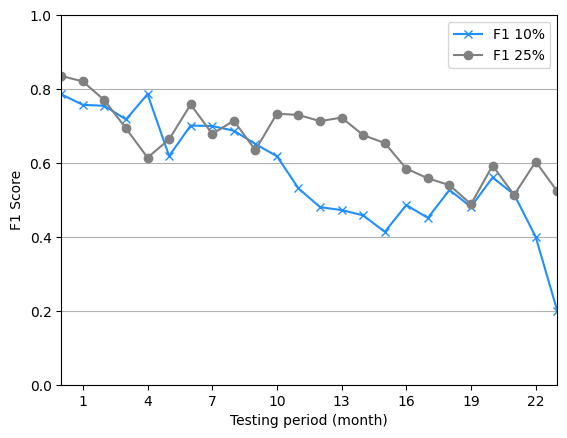

In [16]:
# Reproduce the plot

pendleblue='#1f8fff'
pendleyellow='#ffa600'

plot(results_10['f1'], marker='x', color=pendleblue)
plot(results_25['f1'], marker='o', color='gray')
legend(['F1 10%', 'F1 25%'])
xlim([0, 23])
plt.xticks(ticks=range(1, 24, 3))
ylim([0, 1])
xlabel('Testing period (month)')
ylabel('F1 Score')
grid(axis = 'y')

## MaMaDroid

We can repeat the same procedure for MaMaDroid.

In [1]:
import os
import json
import numpy as np
from datetime import datetime
from sklearn.feature_extraction import DictVectorizer

In [ ]:
from datetime import datetime

PROJ_ROOT = os.path.abspath(os.path.join(os.pardir))
DATA_PATH = os.path.join(PROJ_ROOT, 'data', 'processed')

features_file, labels_file, meta_file = os.path.join(DATA_PATH, 'mamadroidPackages-parrot-v2-down-features-X.json'), os.path.join(DATA_PATH, 'mamadroidPackages-parrot-v2-down-features-Y.json'), os.path.join(DATA_PATH, 'mamadroidPackages-parrot-v2-down-features-meta.json')

with open(features_file) as json_file:
    D = json.load(json_file)
    for datapoint in D:
        del datapoint['sha256']
    vec = DictVectorizer()  
    X = vec.fit_transform(D) # transform key-value (JSON) into sparse feature vector
    
with open(labels_file) as json_file:
    labels = json.load(json_file)
    y = np.array([l[0] for l in labels])
    
with open(meta_file) as json_file:
    meta = json.load(json_file)
    t = list()
    for m in meta:
        timestamp = datetime.strptime(m['dex_date'], '%Y-%m-%dT%H:%M:%S')
        t.append(timestamp)
    t = np.array(t)

In [ ]:
from pylab import *
from tesseract import evaluation, temporal, metrics 
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier

### Training the moedel with 10% malware

In [ ]:
splits = temporal.time_aware_train_test_split(X, y, t, train_size=12, test_size=1, granularity='month')

In [ ]:
clf = RandomForestClassifier(n_estimators=101, max_depth=64, random_state=42)

results_10 = evaluation.fit_predict_update(clf, *splits)

0it [00:00, ?it/s]

22it [06:16, 17.10s/it]/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
23it [06:16, 16.36s/it]/home/users/mbenali/.conda/envs/tesseract/lib/python3.10/site-packages/scikit_learn-1.6.0rc1-py3.10-linux-x86_64.egg/sklearn/metrics/_classification.py:1528: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
24it [06:16, 15.68s/it]


In [ ]:
# Finding the optimal malware ratio in training data
from tesseract import spatial 
# extract splits because we'll need to access X, y and temp individually to find the # optimal malware percentage
X_train, X_test, y_train, y_test, temp_train, temp_test = splits

Figure out the accuracy of the classifier with 10% malware in the training data. We need the accuracy to set the acceptable error rate to 1 - accuracy for optimising for the F1-Score. 

In [ ]:
tp_list = results_10['tp']
tn_list = results_10['tn']
fp_list = results_10['fp']
fn_list = results_10['fn']

# Sum the lists
total_tp = sum(tp_list)
total_tn = sum(tn_list)
total_fp = sum(fp_list)
total_fn = sum(fn_list)

# Calculate accuracy
accuracy = (total_tp + total_tn) / (total_tp + total_tn + total_fp + total_fn)
print(f"Overall Accuracy: {accuracy}")

Overall Accuracy: 0.9185280880146691


### Search for optimal ratio

In [ ]:
clf = RandomForestClassifier(n_estimators=101, max_depth=64, random_state=42)
optimal_malware_training_ratio, aut, error_rate = spatial.find_optimal_train_ratio(
    clf, 
    X_train, 
    y_train, 
    temp_train, 
    proper_train_size=8, # measured in units of `granularity`, taken from X_train, which has 12 months in total
    validation_size=1, # the remaining 4 months, validate 4 times with a validation window of 1 month
    granularity="month", 
    start_tr_rate=0.1, # % of malware in training to start with
    acceptable_errors=1-accuracy,
    end_tr_rate=0.5 # Stop at max 50% malware
)
print(f"Optimal malware training ratio: {optimal_malware_training_ratio}")

4it [03:20, 50.24s/it] 
4it [02:08, 32.13s/it] 
4it [01:40, 25.10s/it]
4it [01:16, 19.03s/it]
4it [01:03, 15.91s/it]
4it [00:56, 14.02s/it]
4it [00:45, 11.39s/it]
4it [00:43, 10.76s/it]
4it [00:36,  9.00s/it]

Optimal malware training ratio: 0.45000000000000007


In [ ]:
clf = RandomForestClassifier(n_estimators=101, max_depth=64, random_state=42)
rates = spatial.search_optimal_train_ratio(
    clf, 
    X_train, 
    y_train, 
    temp_train, 
    proper_train_size=8, # measured in units of `granularity`
    validation_size=1, 
    granularity="month", 
    start_tr_rate=0.1, # % of malware in training to start with
    end_tr_rate=0.5 # Stop at max 50% malware
)

4it [03:18, 49.50s/it] 
4it [02:09, 32.27s/it] 
4it [01:36, 24.03s/it]
4it [01:16, 19.09s/it]
4it [01:05, 16.32s/it]
4it [00:55, 13.92s/it]
4it [00:47, 11.82s/it]
4it [00:42, 10.72s/it]
4it [00:41, 10.49s/it]


In [ ]:
# Put the rates into a dataframe for nicer visualisation
import pandas as pd 

rates = pd.DataFrame(rates)
rates

,errors,auts,phis,fn,fp,total
0,0.062201,0.444532,0.10,806.0,66.0,14019.0
1,0.062487,0.489887,0.15,774.0,102.0,14019.0
2,0.049433,0.636186,0.20,543.0,150.0,14019.0
3,0.048220,0.657220,0.25,483.0,193.0,14019.0
4,0.050289,0.651104,0.30,450.0,255.0,14019.0
5,0.054569,0.665783,0.35,395.0,370.0,14019.0
6,0.059348,0.655563,0.40,349.0,483.0,14019.0
7,0.060703,0.675742,0.45,304.0,547.0,14019.0
8,0.068407,0.662284,0.50,269.0,690.0,14019.0


### Training with 50% ratio

In [ ]:
# Redo splitting
X_train, X_test, y_train, y_test, temp_train, temp_test = temporal.time_aware_train_test_split(X, y, t, train_size=8, test_size=1, granularity='month')

# Downsample so that there's 25% malware in the training data
train_idxs = spatial.downsample_to_rate(y_train, 0.50)

X_train = X_train[train_idxs]
y_train = y_train[train_idxs]
temp_train = temp_train[train_idxs]

In [ ]:
# Train a new classifier 
clf = RandomForestClassifier(n_estimators=101, max_depth=64, random_state=42)
results_50 = evaluation.fit_predict_update(clf, X_train, X_test, y_train, y_test, temp_train, temp_test)

28it [01:10,  2.52s/it]


In [ ]:
metrics.print_metrics(results_50)

------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Test period |     1      2      3      4      5      6      7      8      9     10     11     12     13     14     15     16     17     18     19     20     21     22     23     24     25     26     27     28   
------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
Actual pos  |    399    591    145    147    144    129    215    183    221    216    275    272    354    313    374    369    344    476    635    612    452    278    352    564    148     81     23      8
Actual neg  |   4176   6345   1305   1444   1564   1231   1888   1838   1953   2098   2521   2768   3077   2932   3010   3289   3478   3959   5818   6368   40

In [ ]:
print(f"New robustness over time (measured in AUT): {metrics.aut(results_10, 'f1')}")

New robustness over time (measured in AUT): 0.3040675547613819


### Figure

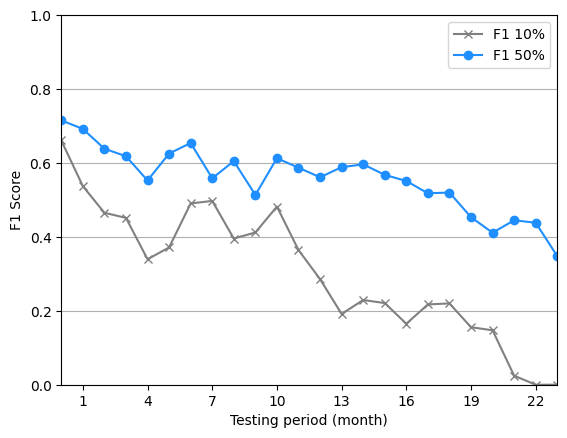

In [ ]:
# Reproduce the plot


plot(results_10['f1'], marker='x', color='grey')
plot(results_25['f1'], marker='o', color=pendleblue)
legend(['F1 10%', 'F1 50%'])
xlim([0, 23])
plt.xticks(ticks=range(1, 24, 3))
ylim([0, 1])
xlabel('Testing period (month)')
ylabel('F1 Score')
grid(axis = 'y')